In [19]:
import numpy as np
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter
from ipywidgets import IntProgress

import torch.multiprocessing as mp

from datetime import datetime

import pdb

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

In [20]:
is_cuda = False
dev = torch.device('cpu')  
if torch.cuda.is_available():
    is_cuda = True
    dev = torch.device('cuda')  

In [21]:
N = 5000
N_train = 3000
N_test = N - N_train

In [22]:
x1 = np.arange(-1, 1, 2/N)
#x2 = np.random.normal(0, 5, N)

#X = np.vstack((x1, x2)).T
X = x1

# Noise
n1 = np.random.normal(0, 0.4, N)*np.abs(x1**2)
n2 = np.random.normal(0, 1, N)*np.abs(x1**2)
n3 = np.random.normal(0, 2, N)*np.abs(x1**2)

#y1_perfect = x1**2 + 5*x1*x2 + 3*np.abs(x2)

y1_perfect = np.abs(6*x1)*np.sin(x1) + np.sin(12*x1)

#y1_perfect = 2*x1 + x1**2


y1 = y1_perfect + n3

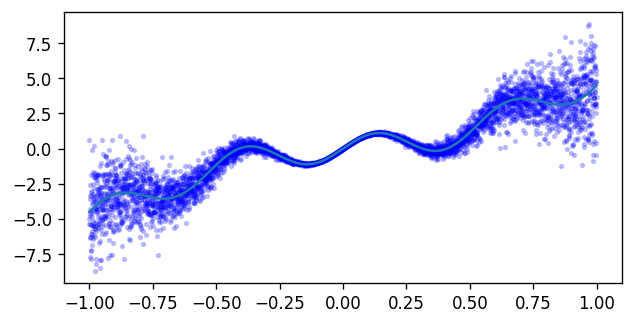

In [23]:
fig,ax = plt.subplots(figsize=(6,3), dpi=120)
plt.plot(X, y1_perfect)
plt.scatter(X, y1, c='blue', alpha=0.2, s=5)

In [24]:
X = torch.tensor(X, dtype=torch.float32)
y1 = torch.tensor(y1, dtype=torch.float32)

In [25]:
try:
    X.shape[1]
except:
    X = X.unsqueeze(1)

X_train, X_test, y_train, y_test = train_test_split(
     X, y1, test_size=0.4, random_state=42)

X_train = torch.tensor(X_train, dtype = torch.float32, requires_grad = True, device = dev)
y_train = torch.tensor(y_train,  dtype = torch.float32, requires_grad = True, device = dev)

X_test = torch.tensor(X_test,  dtype = torch.float32, requires_grad = True, device = dev)
y_test = torch.tensor(y_test,  dtype = torch.float32, requires_grad = True, device = dev)

In [26]:
class ArtificialDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        return

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X_i = self.X[idx]
        y_i = self.y[idx]

        return X_i, y_i

In [27]:
dataset = ArtificialDataset(X, y1)

data_train, data_valid = torch.utils.data.random_split(
    dataset, [N_train, N_test])

In [28]:
BATCH_SIZE = 64

In [29]:
training_loader = torch.utils.data.DataLoader(
    data_train, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=mp.cpu_count())

validation_loader = torch.utils.data.DataLoader(
    data_valid, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=mp.cpu_count())

In [48]:
class VariationalLayer(nn.Module):
    def __init__(self, 
                 input_size, output_size,
                 prior_mu, prior_rho,
                 n_samples
                ):
        super().__init__()
        
        # Bias weight
        input_size = input_size + 1
        
        # Defining Prior distribution (Gaussian)
        self.prior_mu = torch.tensor(prior_mu)
        self.prior_rho = torch.tensor(prior_rho)
        
        # Defining Variational class (Gaussian class)
        self.theta_mu = nn.Parameter(
            torch.Tensor(input_size, output_size).uniform_(
                -0.5, 0.5)).float()
        self.theta_rho = nn.Parameter(
            torch.Tensor(input_size, output_size).uniform_(
                -4,-2)).float()
        
        # Defining some constants
        self.logsqrttwopi = torch.log(
            torch.sqrt(2*torch.tensor(torch.pi)))
        self.K = torch.tensor(1)
        
        # Defining number of samples for forward
        self.n_samples = n_samples
    
    def rho_to_sigma(self, theta_rho):
        return torch.log(1 + torch.exp(theta_rho))

    def sample_weight(self, theta_mu, theta_rho):
        w = (theta_mu 
        + self.rho_to_sigma(theta_rho)*torch.randn(
            (self.n_samples, theta_mu.shape[0], theta_mu.shape[1])
        ))
        return w

    def log_prob_gaussian(self, x, mu, rho):
            return (
                - self.logsqrttwopi
                - self.rho_to_sigma(rho)
                - ((x - mu)**2)/(2*self.rho_to_sigma(rho)**2)
            ).sum(axis=[1, 2]).mean()
    
    def prior(self, w):
        return self.log_prob_gaussian(
            w, self.prior_mu, self.prior_rho)
        
    def variational(self, w, theta_mu, theta_rho):
        return self.log_prob_gaussian(
            w, theta_mu, theta_rho) 
    
    def kl_divergence_layer(self):
        theta_mu = self.theta_mu
        theta_rho = self.theta_rho
        w = self.sample_weight(theta_mu, theta_rho)
        Q = self.variational(w, theta_mu, theta_rho)
        P = self.prior(w)
        KL = Q - P 
        # CHeck if I need to add mean here
        return KL
    
    def forward(self, x_layer):
        theta_mu = self.theta_mu
        theta_rho = self.theta_rho
        w = self.sample_weight(theta_mu, theta_rho)    
        x_next_layer = torch.bmm(x_layer, w[:, :-1, :]) + w[:,-1,:].unsqueeze(1)
        return x_next_layer
    
    
    
class VariationalNet(nn.Module):
    # Initialize the layers
    def __init__(self, n_samples, input_size, output_size):
        super().__init__()
        self.n_samples = n_samples
        self.act1 = nn.ReLU()
        self.act2 = nn.Tanh()
        self.act3 = nn.Sigmoid()
        self.linear1 = VariationalLayer(input_size, 50, 0, 5, n_samples)
        #self.bn = nn.BatchNorm1d(16)
        self.linear2 = VariationalLayer(50, 50, 0, 5, n_samples)
        self.linear3 = VariationalLayer(50, output_size, 0, 5, n_samples)
    
    # Perform the computation
    def forward(self, x):
        #pdb.set_trace()
        x = torch.unsqueeze(x, 0)
        x = x.expand((self.n_samples, x.shape[1], x.shape[2]))
        x = self.linear1(x)
        #x = self.bn(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act1(x)
        x = self.linear3(x)
        return x
    
    def kl_divergence_NN(self):
        kl = (
            self.linear1.kl_divergence_layer() 
            + self.linear2.kl_divergence_layer()
            + self.linear3.kl_divergence_layer()
        )
        return kl

try:
    X_train.shape[1]
except:
    X_train = X_train.unsqueeze(1)
    X_test = X_test.unsqueeze(1)

In [49]:
n_samples = 50
input_size = 1
output_size = 1

In [50]:
h = VariationalNet(n_samples, input_size, output_size).to(dev)
#h1 = ANN(input_size, output_size).to(dev)
#h2 = BayesianNetwork(1).to(dev)
opt_h = torch.optim.Adam(h.parameters(), lr=0.01)

mse_loss_mean = nn.MSELoss(reduction='mean')
mse_loss_sum = nn.MSELoss(reduction='sum')

#X_train = torch.unsqueeze(X_train, 2)
index = np.random.randint(0, 800, 5)
x_h = X_train[index]
y_h = y1_train[index]
h.forward(x_h)

In [51]:
BATCH_SIZE = 256

In [52]:
def generate_batches(data):
    batches_idx = []
    n_batches = int(np.floor(data['d'].nunique() / batch_size))
    for i in range(0, n_batches):
        days = data['d'].unique()
        idx = data[data['d'].isin(
            np.random.choice(days, BATCH_SIZE, replace=False))].index.tolist()
        if len(idx) == n_items*batch_size:
            batches_idx.append(idx)
    return batches_idx

In [53]:
def train_one_epoch(epoch_index):
    
    mse_running_loss = 0.
    kl_running_loss = 0.
    
    n = len(training_loader.dataset)

    for i, data in enumerate(training_loader):
        
        x_batch, y_batch = data
        opt_h.zero_grad()

        y_preds = h(x_batch)
        y_preds_mean = y_preds.mean(axis=0).squeeze()

        mse_loss_ = mse_loss_sum(y_preds_mean, y_batch)
        kl_loss_ = (1/50)*h.kl_divergence_NN()
        
        elbo_loss = mse_loss_ + kl_loss_
        elbo_loss.backward()
        
        opt_h.step()
        
        mse_running_loss += mse_loss_.item()
        kl_running_loss += kl_loss_.item()
        
    mse = mse_running_loss/n
    kl = kl_running_loss/n

    return mse, kl

In [54]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
epoch_number = 0

EPOCHS = 150

for epoch in range(EPOCHS):
    print('------------------EPOCH {}------------------'.format(
        epoch_number + 1))

    h.train(True)
    avg_mse_loss, avg_kl_loss = train_one_epoch(
        epoch_number)
    avg_loss = avg_mse_loss + avg_kl_loss
    
    h.train(False)
    mse_running_loss_v = 0.0
    kl_running_loss_v = 0.0
    
    n = len(validation_loader.dataset)
    
    for i, vdata in enumerate(validation_loader):
        
        x_val_batch, y_val_batch = vdata

        y_val_preds = h(x_val_batch)
        y_val_preds_mean = y_val_preds.mean(axis=0).squeeze()
        
        mse_loss_ = mse_loss_sum(y_val_preds_mean, y_val_batch)
        kl_loss_ = (1/50)*h.kl_divergence_NN()
        elbo_loss = mse_loss_ + kl_loss_
        
        mse_running_loss_v += mse_loss_
        kl_running_loss_v += kl_loss_
        
    avg_vmseloss = (mse_running_loss_v / n).item()
    avg_vklloss = (kl_running_loss_v / n).item()
    
    avg_vloss = avg_vmseloss + avg_vklloss
    
    print('MSE LOSS \t train {} valid {}'.format(
        round(avg_mse_loss, 2), round(avg_vmseloss, 2)))
    print('KL LOSS \t train {} valid {}'.format(
        round(avg_kl_loss, 2), round(avg_vklloss, 2)))
    print('ELBO LOSS \t train {} valid {}'.format(
        round(avg_loss, 2), round(avg_vloss, 2)))

    epoch_number += 1

------------------EPOCH 1------------------
MSE LOSS 	 train 1.74 valid 1.25
KL LOSS 	 train 3.76 valid 3.84
ELBO LOSS 	 train 5.5 valid 5.09
------------------EPOCH 2------------------
MSE LOSS 	 train 1.32 valid 1.21
KL LOSS 	 train 3.75 valid 3.82
ELBO LOSS 	 train 5.07 valid 5.03
------------------EPOCH 3------------------
MSE LOSS 	 train 1.23 valid 1.13
KL LOSS 	 train 3.73 valid 3.79
ELBO LOSS 	 train 4.95 valid 4.91
------------------EPOCH 4------------------
MSE LOSS 	 train 1.17 valid 1.1
KL LOSS 	 train 3.68 valid 3.73
ELBO LOSS 	 train 4.85 valid 4.83
------------------EPOCH 5------------------
MSE LOSS 	 train 1.14 valid 1.12
KL LOSS 	 train 3.61 valid 3.63
ELBO LOSS 	 train 4.74 valid 4.75
------------------EPOCH 6------------------
MSE LOSS 	 train 1.16 valid 1.05
KL LOSS 	 train 3.5 valid 3.52
ELBO LOSS 	 train 4.67 valid 4.56
------------------EPOCH 7------------------
MSE LOSS 	 train 1.11 valid 1.07
KL LOSS 	 train 3.38 valid 3.38
ELBO LOSS 	 train 4.48 valid 4.44
--

MSE LOSS 	 train 0.94 valid 0.95
KL LOSS 	 train -2.69 valid -2.79
ELBO LOSS 	 train -1.74 valid -1.84
------------------EPOCH 59------------------
MSE LOSS 	 train 0.95 valid 0.87
KL LOSS 	 train -2.76 valid -2.86
ELBO LOSS 	 train -1.81 valid -1.99
------------------EPOCH 60------------------
MSE LOSS 	 train 0.91 valid 0.88
KL LOSS 	 train -2.84 valid -2.94
ELBO LOSS 	 train -1.92 valid -2.06
------------------EPOCH 61------------------
MSE LOSS 	 train 0.95 valid 0.86
KL LOSS 	 train -2.91 valid -3.01
ELBO LOSS 	 train -1.96 valid -2.15
------------------EPOCH 62------------------
MSE LOSS 	 train 0.92 valid 0.86
KL LOSS 	 train -2.98 valid -3.08
ELBO LOSS 	 train -2.06 valid -2.21
------------------EPOCH 63------------------
MSE LOSS 	 train 0.9 valid 0.9
KL LOSS 	 train -3.05 valid -3.15
ELBO LOSS 	 train -2.15 valid -2.24
------------------EPOCH 64------------------
MSE LOSS 	 train 0.91 valid 0.86
KL LOSS 	 train -3.12 valid -3.22
ELBO LOSS 	 train -2.21 valid -2.36
-----------

MSE LOSS 	 train 0.9 valid 0.87
KL LOSS 	 train -5.08 valid -5.19
ELBO LOSS 	 train -4.18 valid -4.32
------------------EPOCH 115------------------
MSE LOSS 	 train 0.91 valid 0.9
KL LOSS 	 train -5.09 valid -5.22
ELBO LOSS 	 train -4.18 valid -4.32
------------------EPOCH 116------------------
MSE LOSS 	 train 0.89 valid 0.88
KL LOSS 	 train -5.1 valid -5.22
ELBO LOSS 	 train -4.22 valid -4.34
------------------EPOCH 117------------------
MSE LOSS 	 train 0.88 valid 0.87
KL LOSS 	 train -5.12 valid -5.24
ELBO LOSS 	 train -4.24 valid -4.37
------------------EPOCH 118------------------
MSE LOSS 	 train 0.91 valid 0.87
KL LOSS 	 train -5.14 valid -5.25
ELBO LOSS 	 train -4.23 valid -4.38
------------------EPOCH 119------------------
MSE LOSS 	 train 0.9 valid 0.85
KL LOSS 	 train -5.16 valid -5.28
ELBO LOSS 	 train -4.26 valid -4.43
------------------EPOCH 120------------------
MSE LOSS 	 train 0.89 valid 0.84
KL LOSS 	 train -5.17 valid -5.28
ELBO LOSS 	 train -4.28 valid -4.44
-------

In [55]:
for i in range(0, 5000):
    index = np.random.randint(0, X_train.shape[0], BATCH_SIZE)
    x_h = X_train[index]
    y_h = y_train[index]
    
    opt_h.zero_grad()
    #y_preds_mean = h1(x_h).squeeze()
    
    #elbo_loss = h1.sample_elbo(x_h, y_h, n_samples=3)
    y_preds = h(x_h)
    y_preds_mean = y_preds.mean(axis=0).squeeze()
    
    elbo_loss = 50000*mse_loss(y_preds_mean, y_h) + h.kl_divergence_NN()
    elbo_loss.backward()
    opt_h.step()
    
    if i%100==0:
        print(mse_loss(y_preds_mean, y_h), h.kl_divergence_NN())
    
    #if i%100==0:
    #    print(elbo_loss)

NameError: name 'X_train' is not defined

In [ ]:
def plot_test_curve(X_test, y_test, h):
    xt = torch.hstack(
    (X_test[:,0], 
     torch.tensor(np.arange(-1.4, -1, 1/500), dtype = torch.float32), 
     torch.tensor(np.arange(1, 1.4, 1/500), dtype = torch.float32)))
    
    plt.scatter(X_test[:,0].detach(), y_test.detach())
    for i in range(0, 100):
        plt.scatter(xt.detach(), 
                    h(xt.unsqueeze(1)).detach().squeeze()[0], 
                    color='r', alpha=0.01)
        plt.ylim([-10, 10])

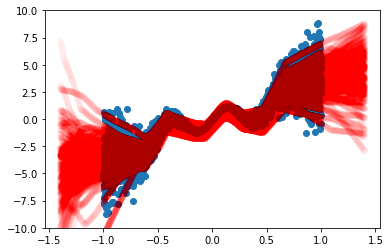

In [56]:
plot_test_curve(validation_loader.dataset.dataset.X,
               validation_loader.dataset.dataset.y,
               h)

In [ ]:
plot_test_curve(validation_loader.dataset.dataset.X,
               validation_loader.dataset.dataset.y,
               h)

In [20]:
plt.scatter(X_test[:,0].detach(), y_test.detach())
for i in range(0, 100):
    plt.scatter(xt.detach(), h(xt.unsqueeze(1)).detach().squeeze()[0], color='r', alpha=0.01)

NameError: name 'X_test' is not defined

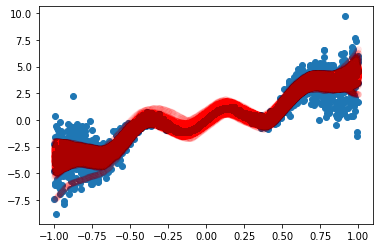

In [255]:
plt.scatter(X_test[:,0].detach(), y_test.detach())
for i in range(0, 100):
    plt.scatter(X_test[:,0].detach(), h(X_test).detach().squeeze()[0], color='r', alpha=0.01)

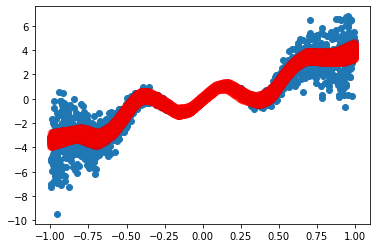

In [65]:
plt.scatter(X_test[:,0].detach(), y_test.detach())
for i in range(0, 100):
    plt.scatter(X_test[:,0].detach(), h2(X_test).detach().squeeze(), color='r', alpha=0.05)

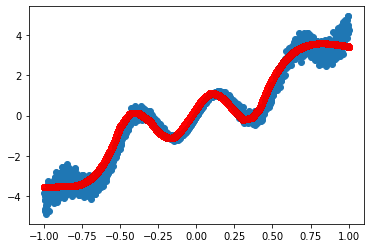

In [146]:
plt.scatter(X_test[:,0].detach(), y_test.detach())
for i in range(0, 100):
    plt.scatter(X_test[:,0].detach(), h1(X_test).detach(), color='r', alpha=0.05)

In [46]:
h(X_test)

tensor([[[-0.0777],
         [-0.0313],
         [-0.0308],
         ...,
         [-0.0832],
         [-0.4016],
         [-0.0270]],

        [[-1.9666],
         [-0.0158],
         [ 0.0933],
         ...,
         [-1.9669],
         [-2.0209],
         [ 0.1892]],

        [[ 0.4750],
         [ 1.0465],
         [ 1.0786],
         ...,
         [ 0.3936],
         [-8.3209],
         [ 1.1201]]], grad_fn=<AddBackward0>)

In [221]:
mse_loss(y_preds_mean, y_h)

tensor(790.9849, grad_fn=<MseLossBackward0>)

In [222]:
h.kl_divergence_NN()

tensor(202.5808, grad_fn=<AddBackward0>)

In [219]:
y_preds_mean

tensor([ 102.2150,  145.6053,   20.7263,   -1.6152,  -31.5738,   10.1983,
          24.0533,   54.6786,  -23.9765,  -69.9426,  -81.3019,  -63.6686,
          92.4034,  131.3438,   99.1495, -111.5350,  -64.6963,  -50.1505,
         197.3893,   64.2947,   50.1944, -111.5350, -140.7539,   68.0634,
         -47.6772,  -27.9659,  190.0887,  -88.2236, -124.4992,    3.7649,
         -46.4705,   40.3146,  160.9212,  -50.7410,  -12.7711,  -72.0561,
         -42.7727,  -75.9347,  108.1896,  160.0007,   27.8732,  228.6359,
         151.4664,  126.0074,   94.7874,  -23.6355,   72.0101,   -5.6030,
         115.2242,   -5.5860], grad_fn=<SqueezeBackward0>)

In [220]:
y_h

tensor([  67.7424,  133.4991,   14.8095,    6.8667,  -10.0592,    1.8639,
          17.4458,   34.9345,  -17.4515,  -60.1327,  -74.0747,  -49.9519,
          70.7016,  130.5905,   71.5508, -148.9616,  -49.9473,  -18.4058,
         237.8830,   51.3122,   14.6421, -148.9616, -246.1836,   55.9984,
         -13.2758,  -34.7388,  145.3001, -127.8421, -188.8626,    5.0664,
         -54.7836,   23.9301,  148.0581,  -41.7343,    2.5848,  -38.4266,
         -18.1399,  -72.8139,  109.4105,  179.5030,   16.9142,  288.7208,
         118.8489,  142.0373,   93.5721,  -16.7625,   66.8598,    3.4595,
         110.7035,    0.8648], grad_fn=<IndexBackward0>)

In [114]:
for name, param in h.named_parameters():
    if param.requires_grad:
        print (name, param.data)

linear1.theta_mu tensor([[[ 0.8771,  0.8008,  0.5494,  0.6440,  0.4596],
         [-0.4487,  0.7498,  0.5977,  0.2930, -0.1289],
         [ 0.8443,  0.6756,  0.3603,  0.5161,  0.5984]],

        [[ 0.7617,  0.4910,  0.6485,  0.7612,  0.8183],
         [ 0.2891, -0.4360, -0.4808,  0.7688, -0.4957],
         [ 0.8583,  0.6387,  0.6754,  0.6904,  0.7762]],

        [[ 0.6100,  0.7565,  0.5851,  0.4265,  0.3386],
         [ 0.1600,  0.5227, -0.3907,  0.5654,  0.0436],
         [ 0.5872,  0.8885,  0.4619,  0.6182,  0.5223]]])
linear1.theta_rho tensor([[[-1.5920, -1.2908, -1.5692, -0.9557, -0.8429],
         [-0.8280, -1.4659, -1.1269, -1.2181, -1.1346],
         [-1.5434, -1.2956, -1.3341, -1.1154, -1.1518]],

        [[-1.3310, -1.8959, -1.3955, -1.7491, -1.6686],
         [-0.7042, -1.4796, -0.7514, -1.0054, -1.0801],
         [-1.7647, -1.1682, -1.3814, -1.2318, -1.2843]],

        [[-1.1970, -1.0642, -1.5848, -1.3141, -1.0779],
         [-1.5442, -1.5914, -1.0839, -1.3320, -0.5853],
   

In [13]:
elbo_loss

tensor(989.9192, grad_fn=<AddBackward0>)

In [12]:
input_size = 2
output_size = 3
vi_obj = VariationalLayer(input_size, output_size, 0, 0.54)

In [13]:
#X_train = torch.unsqueeze(X_train, 2)
index = np.random.randint(0, 800, 4)
x_h = X_train[index]
y_h = y1_train[index]

In [15]:
vi_obj.forward(x_h, 10).shape

torch.Size([5, 3, 10])

In [33]:
elbo_loss(xh, yh, h, w)

NameError: name 'elbo_loss' is not defined

In [192]:
#X_train = torch.unsqueeze(X_train, 2)

In [162]:
w = vi_obj.sample_weight(weight_mu, weight_rho)
Q = vi_obj.variational(w, weight_mu, weight_rho)
P = vi_obj.variational(w)

index = np.random.randint(0, 800, 5)
x_h = X_train[index]
y_h = y1_train[index]
l = mse_loss(h(x_h), y_h)

TypeError: variational() missing 2 required positional arguments: 'theta_mu' and 'theta_rho'

In [193]:
index = np.random.randint(0, 800, 5)
x_h = X_train[index]
y_h = y1_train[index]
l = mse_loss(h(x_h), y_h)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x1 and 2x6)

In [124]:
x_h.shape

torch.Size([200, 2])

In [130]:
h.forward_parallel(x_h)

RuntimeError: Cowardly refusing to serialize non-leaf tensor which requires_grad, since autograd does not support crossing process boundaries.  If you just want to transfer the data, call detach() on the tensor before serializing (e.g., putting it on the queue).

In [58]:
X_train

array([[ 1.41972735,  1.2029036 ],
       [ 3.64036384, -1.80001503],
       [ 1.66258872, -9.45797395],
       ...,
       [ 3.35859904,  2.77637386],
       [ 2.11101038,  5.22272453],
       [ 2.69671436,  2.78818971]])

In [ ]:
P = vi_obj.prior(vi_obj.sample_weight(weight_mu, weight_rho))

In [112]:
index = np.random.randint(0, 800, 200)
x_h = X_train[index]
y_h = y1_train[index]

In [113]:
x_h

tensor([[ 4.2213e+00, -6.2528e+00],
        [ 2.7539e+00,  2.2754e+00],
        [ 4.8483e+00, -3.6463e+00],
        [ 4.6008e+00, -2.2948e+00],
        [ 6.7030e+00, -2.3596e+00],
        [ 1.8571e+00,  6.8027e-01],
        [ 2.9115e+00, -5.4428e+00],
        [ 2.3574e+00, -4.6242e+00],
        [ 4.1867e+00, -5.0198e+00],
        [ 5.5665e+00,  1.7493e+00],
        [ 4.1867e+00, -5.0198e+00],
        [ 1.6467e+00, -1.4431e+00],
        [ 1.7152e+00, -2.6472e+00],
        [ 4.8483e+00, -3.6463e+00],
        [ 3.3220e+00,  3.2644e+00],
        [ 1.7996e+00, -6.0863e+00],
        [ 9.8054e-01,  3.7539e+00],
        [ 5.2619e+00, -2.2712e+00],
        [ 5.8081e+00,  4.0490e+00],
        [ 5.0169e+00,  3.7023e+00],
        [ 7.5814e-01,  3.0518e-01],
        [ 4.2604e+00,  5.6789e+00],
        [ 7.5471e+00, -1.5020e+00],
        [ 6.1520e+00,  4.9272e+00],
        [ 4.3850e+00,  2.8569e+00],
        [ 4.5348e+00,  3.5263e+00],
        [ 3.4467e+00, -4.1564e+00],
        [-1.3712e+00,  3.650

In [114]:
np.random.randint(0,N)

463

In [115]:
mse_loss(h(x_h), y_h)

tensor(8096.7533, dtype=torch.float64, grad_fn=<MseLossBackward0>)

In [174]:
w = sample_weight(weight_mu, weight_rho)

In [175]:
w

tensor([[-0.0181, -0.4754]], grad_fn=<AddBackward0>)

In [176]:
prior(w)

tensor(-3.9496, grad_fn=<SumBackward0>)

In [177]:
variational_posterior(w, weight_mu, weight_rho)

tensor(-4.1615, grad_fn=<SumBackward0>)